In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import json
import configparser
from pathlib import Path
import os

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE
def RMSE(y_real, y_predict):
    return np.sqrt(MSE(y_real, y_predict))

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

configs = configparser.ConfigParser()
configs.read("configuracoes.conf",encoding='utf-8')
data_folder = Path(configs["DEFAULT"]["folder_path"])
path = data_folder / configs["DEFAULT"]["file"]
objeto = configs["DEFAULT"]["objeto"]
regiao = configs["DEFAULT"]["regiao"]

In [2]:
look_back = 12 #Quantidade de meses anteriores usado para prever
forecast_horizon = int(configs["DEFAULT"]["meses"]) #Quantidade de meses previstos

model_mape = []
model_rmse = []

for i in range(0,7):

    #Carrega os dados
    cesta = pd.read_excel(path)
    cesta.drop(['ano', 'salario', 'preco'], axis=1, inplace=True)

    #Cria sequencia de dados do tamanho (meses anterioes + meses a serem previstos)
    for n_step in range(1, look_back + forecast_horizon):
        cesta[f'razao t(h + {n_step})'] = cesta['razao'].shift(-n_step).values
    cesta.dropna(inplace=True)
    cesta.reset_index(drop=True, inplace=True)

    #Divide os dados em Treino e Teste
    X_train = cesta.iloc[:-67:, :look_back:].values
    y_train = cesta.iloc[:-67:, look_back::].values
    X_val = cesta.iloc[-67:-37:, :look_back:].values
    y_val = cesta.iloc[-67:-37:, look_back::].values
    y_val2 = cesta.iloc[-67:-37:, look_back::].values.tolist()

    #remodela as inputs para formato (batchs, months, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

    #Cria o modelo
    model=Sequential()
    model.add(LSTM(32, input_shape=(look_back,1)))
    model.add(Dense(forecast_horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')

    #Treina e pever (forecast_horizon) quantidade de tempo
    history = model.fit(X_train, y_train, epochs= 7, batch_size=1, shuffle=False, validation_data=(X_val, y_val))
    forecast = model.predict(X_val)

    model_rmse.append(RMSE(y_val2, forecast))
    model_mape.append(MAPE(y_val2, forecast) * 100)

model_mape.sort()
model_rmse.sort()
model_mape.pop()
del model_mape[0]
model_rmse.pop()
del model_rmse[0]

mean_rmse = 0
mean_mape = 0

for rmse, mape in zip(model_rmse, model_mape):
    mean_rmse += rmse
    mean_mape += mape

mean_rmse = mean_rmse / 5
mean_mape = mean_mape / 5

"""
resultados = [valor for valor in forecast[0]]
objeto = objeto.replace(" ",'_')
output = {objeto.lower():str(resultados)}
filename = f"previsao_LSTM_{objeto.lower()}_{regiao.lower()}_{forecast_horizon}_meses.json"
pasta_atual = os.getcwd()
full_url = Path(pasta_atual) / 'resultados' / 'previsoes' / filename
os.makedirs(os.path.dirname(full_url), exist_ok=True)
with open(full_url,"w") as file:
    json.dump(output,file,ensure_ascii=False)
print("Arquivo com resultados gerados")
"""

Epoch 1/7
120/120 [==============================] - 2s 6ms/step - loss: 0.0164 - val_loss: 0.0012
Epoch 2/7
120/120 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 3/7
120/120 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 9.2998e-04
Epoch 4/7
120/120 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 8.1937e-04
Epoch 5/7
120/120 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 7.4211e-04
Epoch 6/7
120/120 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 6.8679e-04
Epoch 7/7
120/120 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 6.4692e-04
Epoch 1/7
120/120 [==============================] - 2s 5ms/step - loss: 0.0233 - val_loss: 0.0012
Epoch 2/7
120/120 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 9.7028e-04
Epoch 3/7
120/120 [==============================] - 0s 2ms/step - loss: 0.0017 - val

'\nresultados = [valor for valor in forecast[0]]\nobjeto = objeto.replace(" ",\'_\')\noutput = {objeto.lower():str(resultados)}\nfilename = f"previsao_LSTM_{objeto.lower()}_{regiao.lower()}_{forecast_horizon}_meses.json"\npasta_atual = os.getcwd()\nfull_url = Path(pasta_atual) / \'resultados\' / \'previsoes\' / filename\nos.makedirs(os.path.dirname(full_url), exist_ok=True)\nwith open(full_url,"w") as file:\n    json.dump(output,file,ensure_ascii=False)\nprint("Arquivo com resultados gerados")\n'

In [3]:
print("MAPE = ", round(mean_mape, 5))
print("RMSE = ", round(mean_rmse, 5))

MAPE =  6.26352
RMSE =  0.02479


Text(0, 0.5, 'Loss')

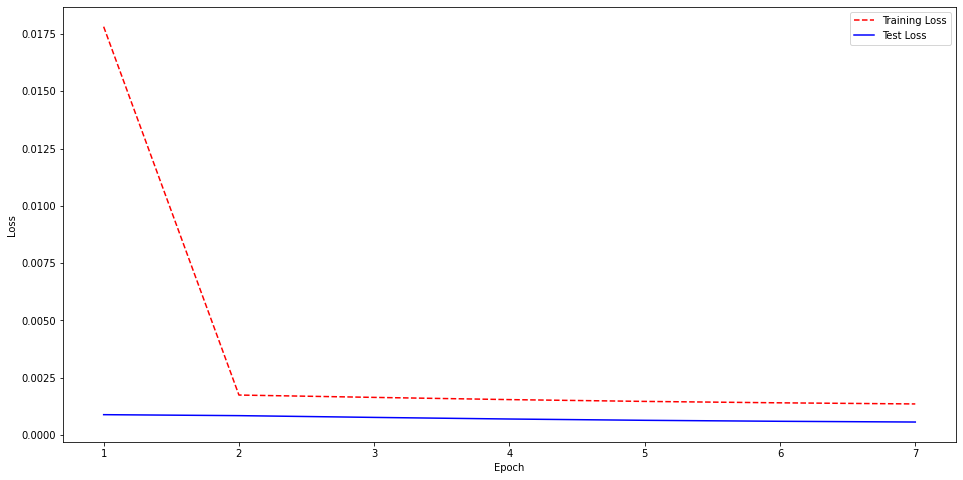

In [4]:

import matplotlib.pyplot as plt

training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
fig = plt.figure(figsize=(16, 8))
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
